# Homework 4:  Further Hyper-parameter Tuning  and visualize performance for event detection model

## Notebook Outline

    1. Further Hyper-parameter Tuning for event classification

    2. Visualize the loss and accuracy of the train and validation datasets during training

In [1]:
# Load the tensorflow, which is a framework for deep learning.
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
# Load numpy library as "np", which can handle large matrices and provides some mathematical functions.
import numpy as np 
# Load pandas as "pd", which is useful when working with data tables. 
import pandas as pd 
# Load the SciPy, which provides many useful tools for scientific computing
import scipy
# Load random, which provide some randomize functions.
import random
# Load a function pyplot as "plt" to plot figures.
import matplotlib.pyplot as plt
# Load functions to calculate precision, and recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Load the VAR function for Vector Autoregression
from statsmodels.tsa.api import VAR

# Setup the random seed for reproducibility
seed = 1234
random.seed(seed)
np.random.seed(seed)

2024-05-04 17:25:23.576944: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 17:25:23.895313: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 17:25:23.897219: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 17:25:24.953574: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# The root directory of the pmuBAGE data
pmuBAGE_data_dir = "../data/pmuBAGE/data"

# Number of the tensor for voltage and frequency
voltage_tensor_number = 31
frequency_tensor_number = 21

# Load each tensors of voltage events and concatenate them as a big tensor.
voltage_tensor_list = []
for idx in range(voltage_tensor_number):
    voltage_sub_tensor = np.load(f"{pmuBAGE_data_dir}/voltage/voltage_{idx}.npy")
    voltage_tensor_list.append(voltage_sub_tensor)
voltage_tensor = np.concatenate(voltage_tensor_list, axis=0)


# Load each tensors of frequency events and concatenate them as a big tensor.
frequency_tensor_list = []
for idx in range(frequency_tensor_number):
    frequency_sub_tensor = np.load(f"{pmuBAGE_data_dir}/frequency/frequency_{idx}.npy")
    frequency_tensor_list.append(frequency_sub_tensor)
frequency_tensor = np.concatenate(frequency_tensor_list, axis=0)

# Transpose the big tensor as (event_idx, timestamp, PMU_idx, measurements)
voltage_tensor = np.transpose(voltage_tensor, (0, 3, 2, 1))
frequency_tensor = np.transpose(frequency_tensor, (0, 3, 2, 1))

# Print the shape of the voltage event
print(voltage_tensor.shape)
print(frequency_tensor.shape)

(620, 600, 100, 4)
(84, 600, 100, 4)


In [3]:
"""
    Use standardization to pre-process the pmu time series data.
    Input  -> two original tensors: voltage_tensor, frequency_tensor
    Output -> two standardized tensors: voltage_tensor_standardized, frequency_tensor_standardized
    Requirement Details: 
        The tensor shape is (number_of_event, timestamps (600), pmus (100), measurements (4))
        For each time sequence (Single pmu measurement sequence, 600 timestamps), standardize them by Z-Score
        z-score = (x - mean) / std
"""

# Voltage tensor

voltage_mean = np.mean(voltage_tensor, axis=1)
voltage_mean = np.expand_dims(voltage_mean, axis=1)
voltage_std = np.std(voltage_tensor, axis=1)
voltage_std = np.expand_dims(voltage_std, axis=1)
voltage_tensor_standardized = np.nan_to_num((voltage_tensor - voltage_mean) / voltage_std)

# Frequency tensor

frequency_mean = np.mean(frequency_tensor, axis=1)
frequency_mean = np.expand_dims(frequency_mean, axis=1)
frequency_std = np.std(frequency_tensor, axis=1)
frequency_std = np.expand_dims(frequency_std, axis=1)
frequency_tensor_standardized = np.nan_to_num((frequency_tensor - frequency_mean) / frequency_std)

print(voltage_tensor_standardized.shape)
print(frequency_tensor_standardized.shape)


(620, 600, 100, 4)
(84, 600, 100, 4)


In [4]:
# Number of the classes
num_classes = 2

# Number of the voltage and frequency events in the dataset
n_voltage = voltage_tensor_standardized.shape[0]
n_frequency = frequency_tensor_standardized.shape[0]

# Define the labels
# Voltage events' label is defined as: 0
voltage_label = np.array([0] * n_voltage)
# Frequency events' label is defined as: 1
frequency_label = np.array([1] * n_frequency)

"""
    Implement the one-hot encoding on the lablel of of the voltage and frequency event labels.
    Input  -> Original voltage and frequency labels (voltage_label, frequency_label)
    Output -> One-hot encoded voltage and frequency labels (voltage_label_onehot, frequency_label_onthot)
    Voltage label: "0" -> "[1, 0]"
    Frequency label: "1" -> "[0, 1]"
    You can use any library or tool for doing this
"""

voltage_label_onehot = tf.keras.utils.to_categorical(voltage_label, num_classes=num_classes)
frequency_label_onthot = tf.keras.utils.to_categorical(frequency_label, num_classes=num_classes)

# Should be [1, 0]
print(voltage_label_onehot[0])
# Should be [0, 1]
print(frequency_label_onthot[0])
# Should be (620, 2)
print(voltage_label_onehot.shape)
# Should be (84, 2)
print(frequency_label_onthot.shape)

[1. 0.]
[0. 1.]
(620, 2)
(84, 2)


In [5]:
voltage_tensor_standarded_permuted = voltage_tensor_standardized[np.random.permutation(n_voltage)]
frequency_tensor_standarded_permuted = frequency_tensor_standardized[np.random.permutation(n_frequency)]

In [6]:
# Seperate the data to train and test
train_portion = 0.7

# Samples
X_voltage = voltage_tensor_standarded_permuted
X_frequency = frequency_tensor_standarded_permuted
# Labels
y_voltage = voltage_label_onehot
y_frequency = frequency_label_onthot

"""
    Seperate the samples and labels to train and test datasets.
    70% of the voltage and frequency samples and labels are combined as training dataset
    30% remainings are combined as testing dataset
    Input  -> X_voltage, X_frequency, y_voltage, y_frequency
    Output -> X_train, y_train, X_test, y_test
        X_train contains 70% of the X_voltage and X_frequency
        y_train contains 70% of the y_voltage and y_frequency
        X_test contains 30% of the X_voltage and X_frequency
        y_test contains 30% of the y_voltage and y_frequency
"""

# X_train
X_train_voltage = X_voltage[:int(n_voltage * train_portion)] 
X_train_frequency = X_frequency[:int(n_frequency * train_portion)]
X_train = np.concatenate([X_train_voltage, X_train_frequency], axis=0)

# y_train
y_train_voltage = y_voltage[:int(n_voltage * train_portion)] 
y_train_frequency = y_frequency[:int(n_frequency * train_portion)]
y_train = np.concatenate([y_train_voltage, y_train_frequency], axis=0)

# X_test
X_test_voltage = X_voltage[int(n_voltage * train_portion):] 
X_test_frequency = X_frequency[int(n_frequency * train_portion):]
X_test = np.concatenate([X_test_voltage, X_test_frequency], axis=0)

# y_test
y_test_voltage = y_voltage[int(n_voltage * train_portion):] 
y_test_frequency = y_frequency[int(n_frequency * train_portion):]
y_test = np.concatenate([y_test_voltage, y_test_frequency], axis=0)


"""
    Seperate the Training Dataset to Training (80%) and Validation (20%).
    Perform the hyper-parameter tuning to find the best parameter combination.
    
"""

val_portaton = 0.2

n_voltage_train = int(n_voltage * train_portion)
n_frequency_train = int(n_frequency * train_portion)

X_train_voltage = X_voltage[:int(n_voltage * train_portion)] 
X_train_frequency = X_frequency[:int(n_frequency * train_portion)]
X_train = np.concatenate([X_train_voltage, X_train_frequency], axis=0)

# X_val_hp
X_val_hp_voltage = X_train[:int(n_voltage_train * val_portaton)]
X_val_hp_frequency = X_train[n_voltage_train: n_voltage_train + int(n_frequency_train * val_portaton)]
X_val_hp = np.concatenate([X_val_hp_voltage, X_val_hp_frequency], axis=0)

# y_val_hp
y_val_hp_voltage = y_train[:int(n_voltage_train * val_portaton)]
y_val_hp_frequency = y_train[n_voltage_train: n_voltage_train + int(n_frequency_train * val_portaton)]
y_val_hp = np.concatenate([y_val_hp_voltage, y_val_hp_frequency], axis=0)


# X_train_hp
X_train_hp_voltage = X_train[int(n_voltage_train * val_portaton): n_voltage_train]
X_train_hp_frequency = X_train[n_voltage_train + int(n_frequency_train * val_portaton):]
X_train_hp = np.concatenate([X_train_hp_voltage, X_train_hp_frequency], axis=0)

# y_train_hp
y_train_hp_voltage = y_train[int(n_voltage_train * val_portaton): n_voltage_train]
y_train_hp_frequency = y_train[n_voltage_train + int(n_frequency_train * val_portaton):]
y_train_hp = np.concatenate([y_train_hp_voltage, y_train_hp_frequency], axis=0)


X_train, y_train = X_train_hp, y_train_hp
X_val, y_val = X_val_hp, y_val_hp


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (395, 600, 100, 4)
y_train shape: (395, 2)
X_val shape: (97, 600, 100, 4)
y_val shape: (97, 2)
X_test shape: (212, 600, 100, 4)
y_test shape: (212, 2)


## 1. Further Hyper-parameter Tuning for event classification

In [7]:
def build_model():
    """
        Feel free to change the structure of the model
    """
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(600, 100, 4)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

In [8]:
# Further Hyper-parameters


##-----------------------------------------------------------------------##
##---------------------Students start filling below----------------------##
##-----------------------------------------------------------------------##


"""
    Try different combination of the hyper-parameters. 
    Using grid search to get the best hyper-parameters
    Choose the best hyper-parameter combination to train the final model.
    Pick your own hyper-parameters and search range.
"""

# Hyper-parameters

learning_rates = [0.0001, 0.003]
batch_sizes = [10, 20]
training_epochs = [15, 25]
loss_func = tf.keras.losses.CategoricalCrossentropy()

best_hyperparameter = {"learning_rate": 0, "batch_size": 0, "training_epoch": 0}
best_accuracy_val = 0.0


for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for training_epoch in training_epochs:
            print(f"Current hyper-parameters: learning_rate: {learning_rate}, batch_size: {batch_size}, training_epoch: {training_epoch}.")
            
            # build model
            model_tuning = build_model()
            # Train the model with the above hyper-parameters
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

            model_tuning.compile(optimizer=optimizer, loss=loss_func, metrics=['categorical_accuracy'])

            history_2 = model_tuning.fit(X_train_hp, y_train_hp, epochs=training_epoch, batch_size=batch_size, validation_data=(X_val_hp, y_val_hp))
    
            # Evaluate the hyper-parameter tuning neural network
            loss_val, accuracy_val = model_tuning.evaluate(X_val_hp, y_val_hp)
            print(f"Current validation accuracy is: {accuracy_val}.\n")
            
            if accuracy_val > best_accuracy_val:
                best_accuracy_val = accuracy_val
                best_hyperparameter["learning_rate"] = learning_rate
                best_hyperparameter["batch_size"] = batch_size
                best_hyperparameter["training_epoch"] = training_epoch
            tf.keras.backend.clear_session()
            
            
print(f"best validation accuracy is: {best_accuracy_val}")
print(f"best hyper-parameter setting is: {best_hyperparameter}")


##-----------------------------------------------------------------------##
##------------------------------End filling------------------------------##
##-----------------------------------------------------------------------##


Current hyper-parameters: learning_rate: 0.0001, batch_size: 10, training_epoch: 15.
Epoch 1/15
40/40 [==============================] - 15s 368ms/step - loss: 0.2965 - categorical_accuracy: 0.8886 - val_loss: 0.1780 - val_categorical_accuracy: 0.9485
Epoch 2/15
40/40 [==============================] - 15s 373ms/step - loss: 0.1553 - categorical_accuracy: 0.9494 - val_loss: 0.1429 - val_categorical_accuracy: 0.9485
Epoch 3/15
40/40 [==============================] - 15s 376ms/step - loss: 0.1275 - categorical_accuracy: 0.9620 - val_loss: 0.1573 - val_categorical_accuracy: 0.9485
Epoch 4/15
40/40 [==============================] - 15s 388ms/step - loss: 0.0927 - categorical_accuracy: 0.9797 - val_loss: 0.1174 - val_categorical_accuracy: 0.9691
Epoch 5/15
40/40 [==============================] - 15s 379ms/step - loss: 0.0817 - categorical_accuracy: 0.9696 - val_loss: 0.1136 - val_categorical_accuracy: 0.9691
Epoch 6/15
40/40 [==============================] - 14s 341ms/step - loss: 0.050

## 2. Visualize the loss and accuracy of the train and validation datasets during training

In [9]:
# Training the model on the best parameters found in the previous cell.

lr = 0.003
batch_size = 10
training_epoch = 25

improved_model = build_model()

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_func = tf.keras.losses.CategoricalCrossentropy()

improved_model.compile(optimizer=optimizer, loss=loss_func, metrics=['categorical_accuracy'])

improved_model_history = improved_model.fit(X_train, y_train, epochs=training_epoch, batch_size=batch_size)

# Evaluate the neural network
loss, accuracy = improved_model.evaluate(X_test, y_test)
print(f"The accuracy of the neural network on the test dataset is: {accuracy}.")


Epoch 1/25
40/40 [==============================] - 15s 346ms/step - loss: 0.5175 - categorical_accuracy: 0.8709
Epoch 2/25
40/40 [==============================] - 13s 335ms/step - loss: 0.2120 - categorical_accuracy: 0.8962
Epoch 3/25
40/40 [==============================] - 14s 359ms/step - loss: 0.1866 - categorical_accuracy: 0.9392
Epoch 4/25
40/40 [==============================] - 16s 391ms/step - loss: 0.2410 - categorical_accuracy: 0.9241
Epoch 5/25
40/40 [==============================] - 14s 345ms/step - loss: 0.1765 - categorical_accuracy: 0.9494
Epoch 6/25
40/40 [==============================] - 14s 358ms/step - loss: 0.1498 - categorical_accuracy: 0.9418
Epoch 7/25
40/40 [==============================] - 13s 326ms/step - loss: 0.1352 - categorical_accuracy: 0.9671
Epoch 8/25
40/40 [==============================] - 12s 310ms/step - loss: 0.1321 - categorical_accuracy: 0.9544
Epoch 9/25
40/40 [==============================] - 13s 327ms/step - loss: 0.0943 - categorical_

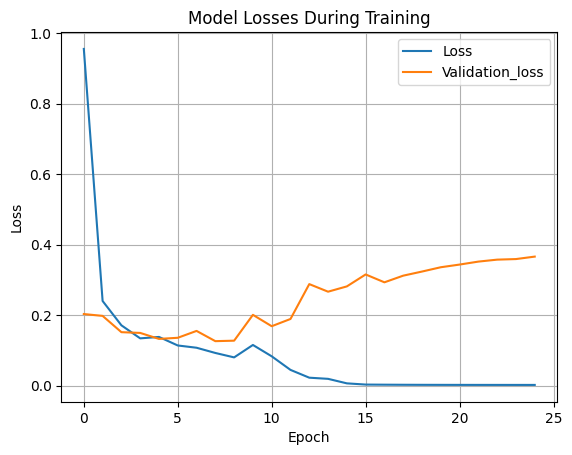

' End Filling '

In [14]:
##-----------------------------------------------------------------------##
##---------------------Students start filling below----------------------##
##-----------------------------------------------------------------------##

# The plotting codes obtained from the presentation of the last class.

"""
    Plot the loss of the training and validation datasets changes during the training.
    The information of the loss during the training is stored in "history" (return from model.fit()).
    Useful resource: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
"""


""" Filling code below """
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation_loss')
plt.title('Model Losses During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()
plt.close()

""" End Filling """

##-----------------------------------------------------------------------##
##------------------------------End filling------------------------------##
##-----------------------------------------------------------------------##

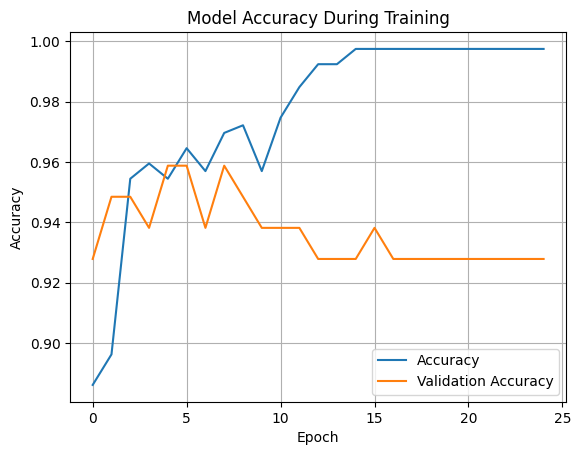

' End Filling '

In [17]:
##-----------------------------------------------------------------------##
##---------------------Students start filling below----------------------##
##-----------------------------------------------------------------------##

"""
    Plot the accuracy on the training and validation datasets during the training.
    The information of the accuracy during the training is stored in "history" (return from model.fit()).
    Useful resource: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
"""


""" Filling code below """

acc = history_2.history['categorical_accuracy']
val_acc = history_2.history['val_categorical_accuracy']
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid()
plt.show()
plt.close()

""" End Filling """

##-----------------------------------------------------------------------##
##------------------------------End filling------------------------------##
##-----------------------------------------------------------------------##